## Imports

In [123]:
import os
import sys
import pathlib
import warnings
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import seaborn as sns

import copy
import gymnasium as gym
import pickle
import mujoco

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from llmicl.interfaces import trainers

from scipy.stats import uniform, kstwobign
from scipy.special import kolmogorov
from sklearn.metrics import r2_score, mean_squared_error

## states and actions names

In [7]:
state_names = {
    "HalfCheetah": [
        "rootx",
        "rootz",
        "rooty",
        "bthigh",
        "bshin",
        "bfoot",
        "fthigh",
        "fshin",
        "ffoot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "bthigh_dot",
        "bshin_dot",
        "bfoot_dot",
        "fthigh_dot",
        "fshin_dot",
        "ffoot_dot",
    ],
    "Hopper": [
        "rootx",
        "rootz",
        "rooty",
        "thigh",
        "leg",
        "foot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_dot",
        "leg_dot",
        "foot_dot",
    ]
}
action_names = {
    "HalfCheetah": [
        "t_bthigh",
        "t_bshin",
        "t_bfoot",
        "t_fthigh",
        "t_fshin",
        "t_ffoot",
    ],
    "Hopper": [
        "thigh_joint",
        "leg_joint",
        "foot_joint",
    ]
}

# Helpers

## load model and tokenizer

In [8]:
import torch
from transformers import (
    LlamaForCausalLM, 
    AutoTokenizer
)

tokenizer = AutoTokenizer.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    use_fast=False,
)
print(f"finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    device_map="auto",   
    torch_dtype=torch.bfloat16, 
)
print(f"finish loading model")
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


finish loading tokenizer


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

## policy classes

In [16]:
LOG_STD_MAX = 2
LOG_STD_MIN = -5

class Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, np.prod(env.single_action_space.shape))
        self.fc_logstd = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = LOG_STD_MIN + 0.5 * (LOG_STD_MAX - LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean, std

def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)
        return env
    return thunk

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class PPOAgent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, np.prod(envs.single_action_space.shape)), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return (
            action,
            probs.log_prob(action).sum(1),
            probs.entropy().sum(1),
            self.critic(x),
            action_mean,
            action_std
        )

class TD3Actor(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mu = nn.Linear(256, np.prod(env.single_action_space.shape))
        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc_mu(x))
        return x * self.action_scale + self.action_bias

## mujoco set and get state

In [17]:
# Extract the state from the MuJoCo model and data
def get_mujoco_state(env):
    model = env.unwrapped.model
    data = env.unwrapped.data
    state = {
        'qpos': data.qpos.copy(),
        'qvel': data.qvel.copy(),
        'act': data.act.copy(),
        'ctrl': data.ctrl.copy(),
        'mocap_pos': data.mocap_pos.copy(),
        'mocap_quat': data.mocap_quat.copy(),
        'userdata': data.userdata.copy(),
        'time': data.time,
    }
    return state

# Set the state back into the MuJoCo model and data
def set_mujoco_state(env, state):
    data = env.unwrapped.data
    data.qpos[:] = state['qpos']
    data.qvel[:] = state['qvel']
    data.act[:] = state['act']
    data.ctrl[:] = state['ctrl']
    data.mocap_pos[:] = state['mocap_pos']
    data.mocap_quat[:] = state['mocap_quat']
    data.userdata[:] = state['userdata']
    data.time = state['time']
    mujoco.mj_forward(env.unwrapped.model, data)

# Main loop

## helper fn

In [128]:
def rollout(max_episode_length=1000, context_length=400, init_index=0):
    obs_next, _ = env.reset()
    restart = True
    df_lines = []
    episode_states = []
    track_entropy = 0.0
    for step in range(max_episode_length):
        obs = obs_next
        line = []
        line.append(obs[None, ...])
        if 'sac' in policy_path:
            action, _, action_mean, std = actor.get_action(
                torch.Tensor(obs[None, ...]).to(device)
            )
            entropy = 0.5 + 0.5 * torch.log(2 * torch.tensor(np.pi)) + std.log()
        elif ('td3' in policy_path) or ('ddpg' in policy_path):
            action = actor(torch.Tensor(obs[None, ...]).to(device))
            action += torch.normal(0, actor.action_scale * 0.1)
            entropy = 0.5 + 0.5 * torch.log(2 * torch.tensor(np.pi)) + (actor.action_scale * 0.1).log()
        elif 'ppo' in policy_path:
            action, _, entropy, _, action_mean, _ = actor.get_action_and_value(
                torch.Tensor(obs[None, ...]).to(device)
            )
        track_entropy += float(entropy.detach().cpu().numpy().mean())
        action = action.detach().cpu().numpy().flatten()
        line.append(action[None, ...])
        env_state = get_mujoco_state(env)
        obs_next, reward, terminated, truncated, _ = env.step(action)
        line.append(np.array([reward])[None, ...])
        line.append(np.array([int(restart)])[None, ...])
        line = np.concatenate(line, axis=1)
        df_lines.append(line)
        restart = False
        episode_states.append((obs_next, get_mujoco_state(env)))
        if terminated or truncated:
            break
    track_entropy /= max_episode_length
    
    assert len(df_lines) > context_length, "Error"
    
    data = np.concatenate(df_lines, axis=0)
    
    time_series = data[
        init_index : init_index + context_length, :n_observations
    ]

    return time_series, data, track_entropy

def icl(model, tokenizer, time_series, context_length, n_observations, n_actions, rescale_factor = 7.0, up_shift = 1.5):
    trainer = trainers.RLICLTrainer(
        model=model,
        tokenizer=tokenizer,
        n_observations=n_observations,
        n_actions=n_actions,
        rescale_factor=rescale_factor,
        up_shift=up_shift,
    )
    
    trainer.update_context(
        time_series=copy.copy(time_series),
        mean_series=copy.copy(time_series),
        sigma_series=np.zeros_like(time_series),
        context_length=context_length,
        update_min_max=True,
    )
    
    trainer.icl_parallel(verbose=1, stochastic=True)
    
    return trainer.compute_statistics()

def compute_metrics(data, icl_object, n_traces, n_observations, init_index=0, rescale_factor = 7.0, up_shift = 1.5):
    """
    Computes the KS metric for a given model and test dataset.

    Parameters:
    - X_test: DataFrame containing ground truth values.
    - model: A model that predicts a categorical distribution over a discretization of the ground truth variable.
    - target_column_names: List of target column names in X_test.
    - n_traces: Number of traces (samples) to generate for each prediction.
    - future_length: Number of future time steps to predict.

    Returns:
    - kss: Array containing the KS metrics for each target and horizon.
    """

    # shape of predictions: observations.reshape(n_samples, n_traces)
    # shape of groundtruth: (n_samples,) or (n_samples, 1)
    n_samples = len(icl_object[0].PDF_list)

    kss = np.zeros((n_observations,))
    r2s = np.zeros((n_observations,))
    mses = np.zeros((n_observations,))
    ks_quantiles = np.zeros((n_observations, n_samples))
    for dim in range(n_observations):
        predictions = np.empty((n_samples, n_traces))
        for t in range(n_samples):      
            PDF = icl_object[dim].PDF_list[t]
            
            ts_min = icl_object[dim].rescaling_min
            ts_max = icl_object[dim].rescaling_max
            
            bin_center_arr = ((PDF.bin_center_arr - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
            bin_height_arr = PDF.bin_height_arr / np.sum(PDF.bin_height_arr)

            samples = np.random.choice(
                bin_center_arr,
                p=PDF.bin_height_arr / np.sum(PDF.bin_height_arr),
                size=(n_traces,)
            )

            predictions[t, :] = copy.copy(samples)

        groundtruth = data[init_index+1:init_index+context_length+1, dim].flatten()

        # Compute quantiles
        quantiles = np.sort(np.array([g > m for g, m in zip(groundtruth, predictions)]).sum(axis=1))
        quantiles = quantiles / n_traces

        # Compute KS metric
        kss[dim] = np.max(np.abs(quantiles - (np.arange(len(quantiles)) / len(quantiles))))
        ks_quantiles[dim, :] = quantiles

        # r2
        mean_predictions = predictions.mean(axis=1)
        r2s[dim] = r2_score(groundtruth, mean_predictions)
        mses[dim] = mean_squared_error(groundtruth, mean_predictions)

    return kss, ks_quantiles, r2s, mses

## main

In [129]:
env_name = "HalfCheetah"
env = gym.make(env_name)
n_actions = env.action_space.shape[0]
n_observations = env.observation_space.shape[0]
context_length = 400
n_traces = 100
algos = ['ddpg', 'sac', 'td3', 'ppo',] # 'ddpg']
policy_path_dict = {
    'sac': "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__sac_continuous_action__1__1723208574",
    'td3': "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__td3__1__1723562307",
    'ppo': "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__ppo_checkpoints__7__1724072335",
    'ddpg': "/home/abenechehab/cleanrl/runs/HalfCheetah-v4__ddpg__1__1723553922",
}
policy_checkpoint_list = [10000, 20000, 30000, 50000, 100000, 200000, 300000, 400000, 500000, 750000, 850000, 990000]
columns = ['dim', 'algo', 'policy', 'entropy', 'state_coverage', 'ks', 'r2', 'mse']
df = pd.DataFrame(columns=columns)
for algorithm in tqdm(algos, desc='algo'):
    for policy_checkpoint in tqdm(policy_checkpoint_list, desc='policy'):
        policy_path = policy_path_dict[algorithm]
        # load actor
        envs = gym.vector.SyncVectorEnv([make_env(env_name, seed=7, idx=0, capture_video=False, run_name="")])
        if algorithm=='sac':
            actor = Actor(envs).to(device)
            actor.load_state_dict(torch.load(f"{policy_path}/actor_checkpoint_{policy_checkpoint}.pth"))
        elif (algorithm=='td3') or (algorithm=='ddpg'):
            actor = TD3Actor(envs).to(device)
            actor.load_state_dict(torch.load(f"{policy_path}/actor_checkpoint_{policy_checkpoint}.pth"))
        else:
            actor = PPOAgent(envs).to(device)
            actor.load_state_dict(torch.load(f"{policy_path}/agent_checkpoint_{policy_checkpoint}.pth"))
        actor.eval()

        time_series, data, entropy = rollout(max_episode_length = 1000, context_length = 400)

        icl_object = icl(
            model=model, 
            tokenizer=tokenizer, 
            time_series=time_series, 
            context_length=context_length, 
            n_observations=n_observations, 
            n_actions=n_actions, 
            rescale_factor=7.0, 
            up_shift=1.5
        )

        kss, ks_quantiles, r2s, mses = compute_metrics(data, icl_object, n_traces, n_observations)

        for dim in range(n_observations):
            df = pd.concat([df, pd.DataFrame(
                [[
                    state_names[env_name][dim], 
                    algorithm, 
                    policy_checkpoint, 
                    entropy, 
                    float(time_series[:,dim].max()-time_series[:,dim].min()), 
                    kss[dim], 
                    r2s[dim],
                    mses[dim],
                ]],
                columns=columns
            )], axis=0)
df.to_csv('/mnt/vdb/abenechehab/entropy_state_cov_corr.csv')
df.head()

policy:   0%|                                                                                                     | 0/12 [00:00<?, ?it/s]/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(


icl / state dim:   0%|                                                                                            | 0/17 [00:00<?, ?it/s]

icl / state dim:  24%|███████████████████▊                                                                | 4/17 [00:00<00:00, 34.68it/s]

icl / state dim:  47%|███████████████████████████████████████▌                                            | 8/17 [00:00<00:00, 34.80it/s]

icl / state dim:  71%|██████████████████████████████████████████████████████████▌                        | 12/17 [00:00<00:00, 34.67it/s]

icl / state dim: 100%|██████████████████████████████████

,dim,algo,policy,entropy,state_coverage,ks,r2,mse
0,rootx,ddpg,10000,-0.883647,0.260632,0.0375,-0.581282,0.000453
0,rootz,ddpg,10000,-0.883647,0.112969,0.0575,0.355020,0.000185
0,rooty,ddpg,10000,-0.883647,0.271558,0.0600,0.135357,0.001337
0,bthigh,ddpg,10000,-0.883647,0.292157,0.0625,0.136819,0.002062
0,bshin,ddpg,10000,-0.883647,0.431112,0.0725,0.029106,0.002725


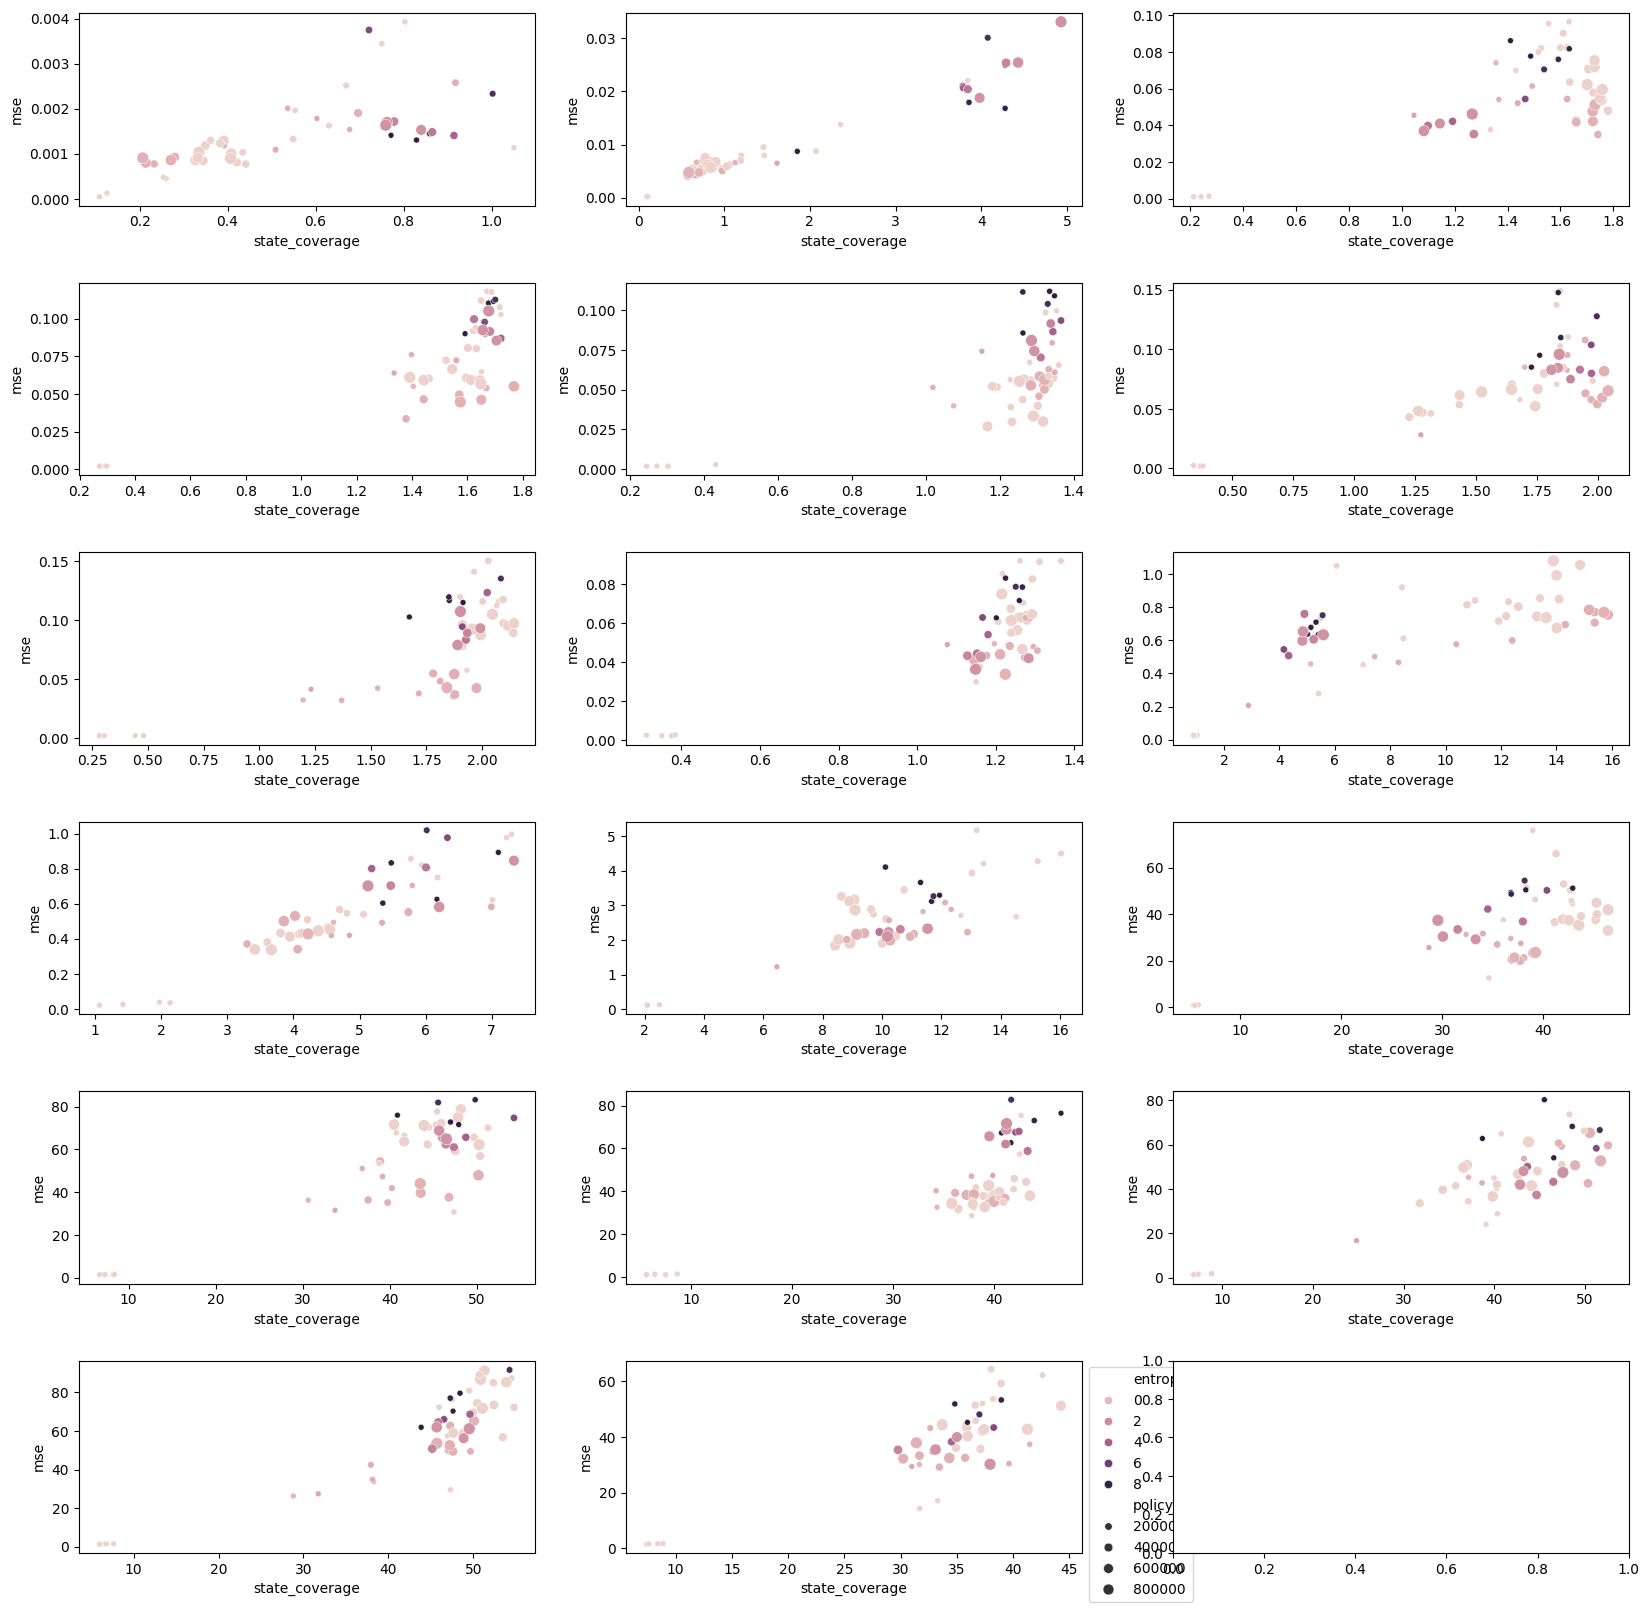

In [138]:
f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.2, 'hspace':0.4})
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    sns.scatterplot(
        data=df[df['dim']==state_names[env_name][dim]], 
        x='state_coverage', 
        y='mse', 
        hue='entropy', 
        size='policy',
        ax=axes[dim],
        legend=None if dim<n_observations-1 else True
    )
sns.move_legend(axes[dim], "upper left", bbox_to_anchor=(1, 1))
plt.show()

/tmp/ipykernel_2394758/194238921.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax = sns.scatterplot(data=df.groupby(['algo', 'policy']).mean(), x='state_coverage', y='r2', hue='policy', style='algo')


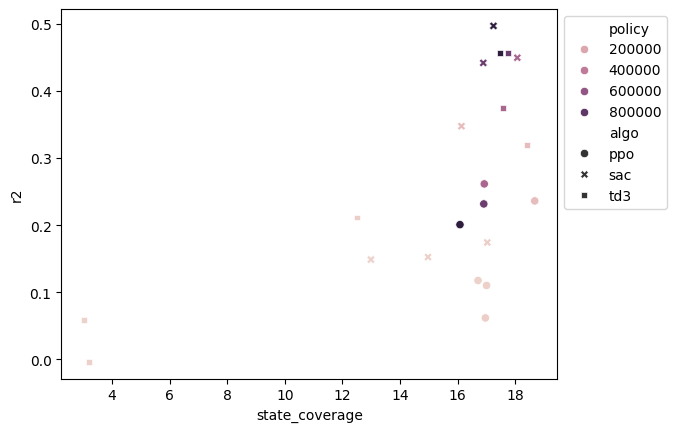

In [74]:
ax = sns.scatterplot(data=df.groupby(['algo', 'policy']).mean(), x='state_coverage', y='r2', hue='policy', style='algo')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

/tmp/ipykernel_2394758/466437160.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=df.groupby(['algo', 'policy']).mean().reset_index(),


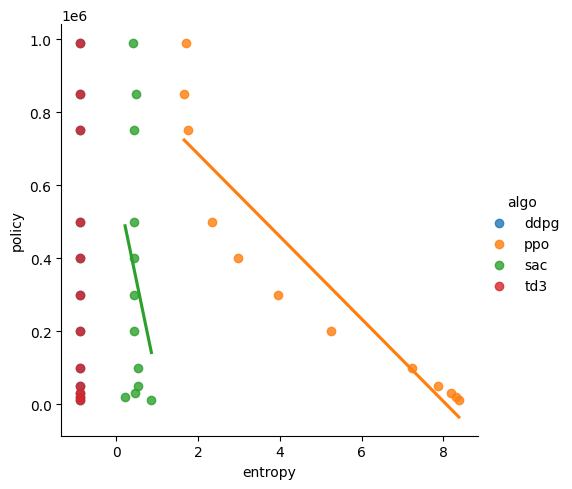

In [140]:
ax = sns.lmplot(
    data=df.groupby(['algo', 'policy']).mean().reset_index(), 
    x='entropy', 
    y='policy', 
    hue='algo', 
    # style='algo
    ci=None
)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


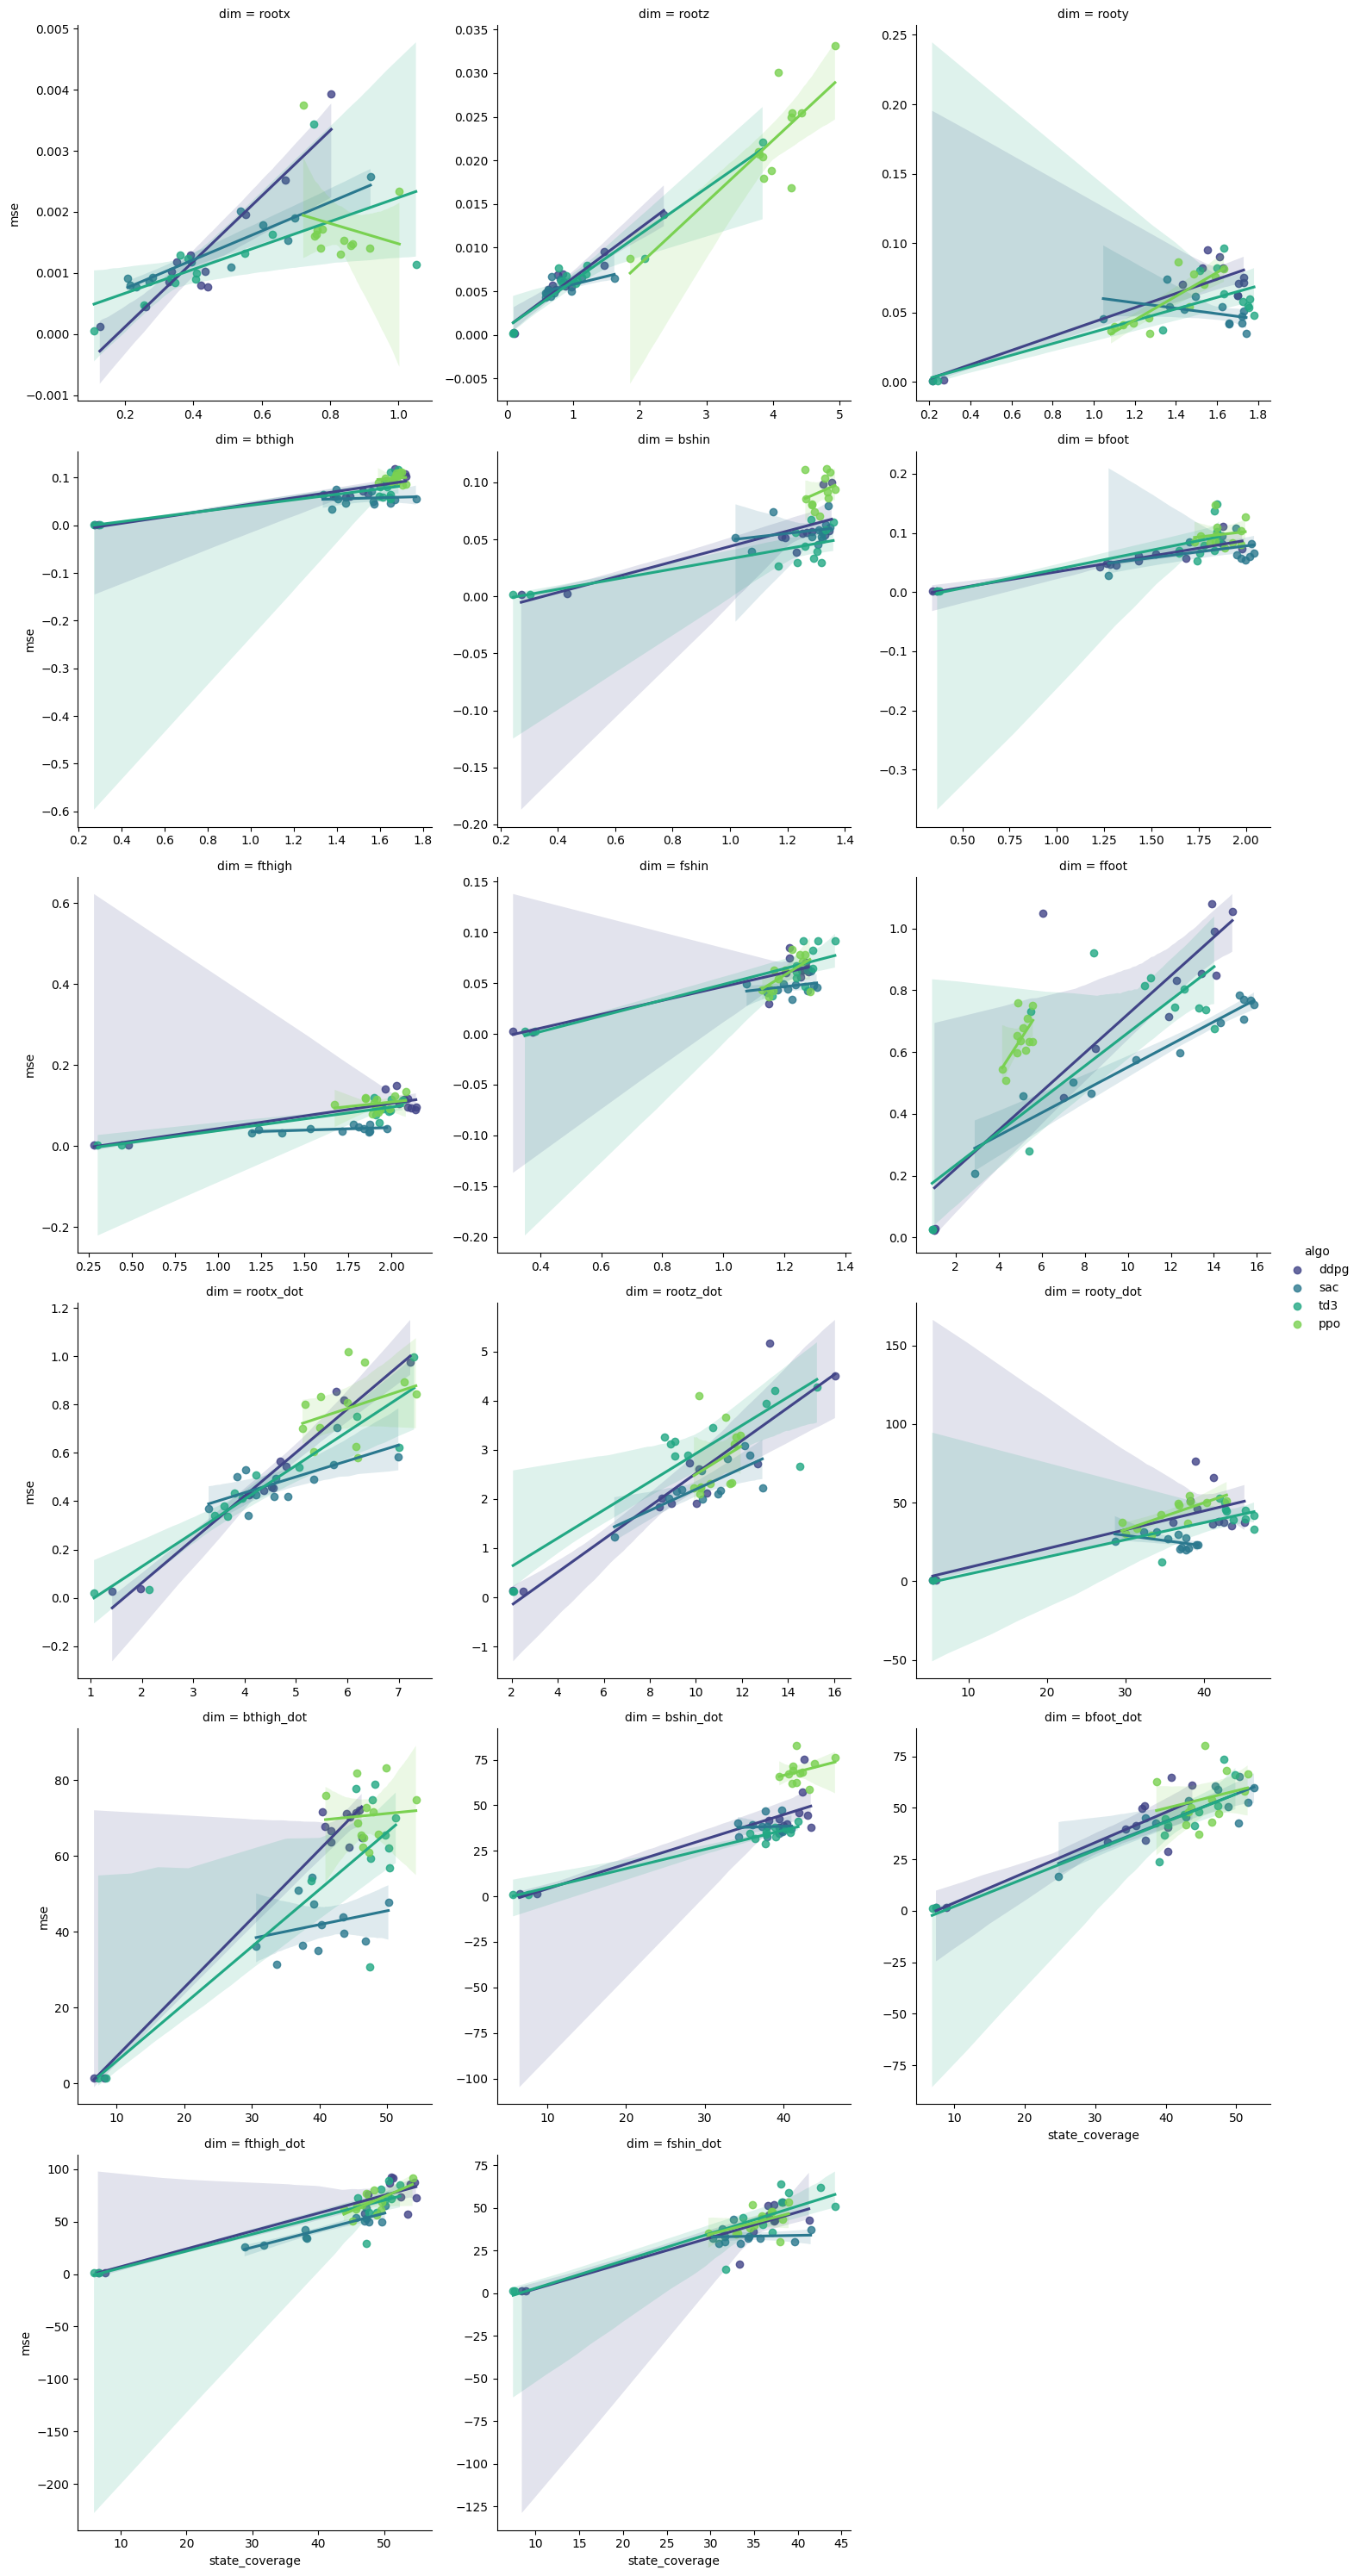

In [137]:
ax = sns.lmplot(
    data=df, 
    x='state_coverage', 
    y='mse', 
    hue='algo', 
    # style='algo'
    col = 'dim', # creates a seperate plot for each region
    col_wrap = 3,  # wraps columns so not all side by side
    sharex=False, sharey=False,
    palette='viridis',
    # ci=None
)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()


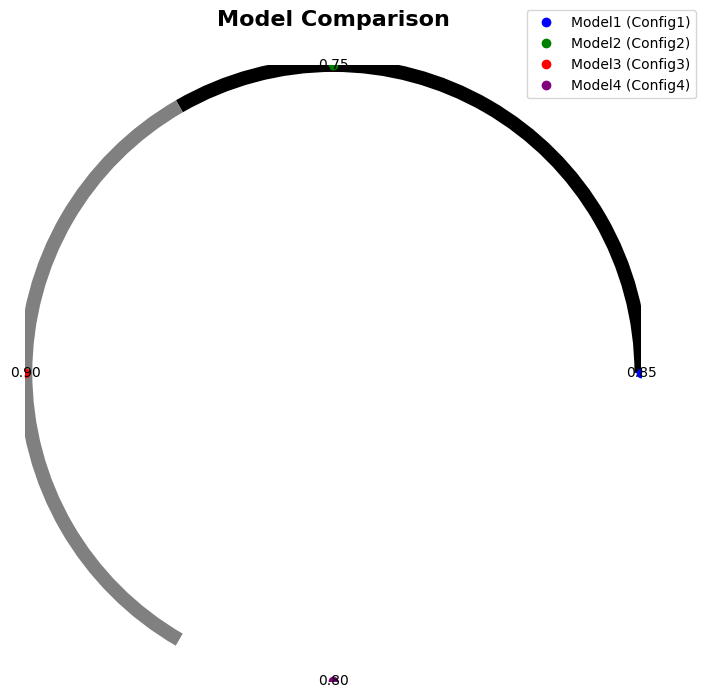

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

# Sample data
data = {
    'model': ['Model1', 'Model2', 'Model3', 'Model4'],
    'config': ['Config1', 'Config2', 'Config3', 'Config4'],
    'metric': [0.85, 0.75, 0.90, 0.80]
}
df = pd.DataFrame(data)

# Define Y_SIZE based on the metric
Y_SIZE = 1.2  # Adjust as needed

# Prepare plot elements
fig, ax = plt.subplots(figsize=(8, 8))
palette = ['blue', 'green', 'red', 'purple']

# Draw arcs
for j, color in enumerate(['black', 'grey', 'white']):
    arc = Arc((0, 0), 2 * Y_SIZE, 2 * Y_SIZE, theta1=j * 120, theta2=j * 120 + 120, color=color, linewidth=10)
    ax.add_patch(arc)

# Plot data for each model
angles = np.linspace(0, 2 * np.pi, len(df) + 1)[:-1]
for i, (model, config, metric_value) in df.iterrows():
    x = np.cos(angles[i]) * Y_SIZE
    y = np.sin(angles[i]) * Y_SIZE
    ax.plot(x, y, 'o', color=palette[i], label=f'{model} ({config})')
    ax.text(x, y, f'{metric_value:.2f}', ha='center', va='center', fontsize=10)

# Set axis formatting
ax.set_xlim(-Y_SIZE, Y_SIZE)
ax.set_ylim(-Y_SIZE, Y_SIZE)
ax.set_aspect('equal')
ax.set_title('Model Comparison', fontsize=16, y=1.05, fontweight="bold")
ax.axis('off')  # Hide the axis

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Display the plot
# plt.tight_layout()
plt.show()


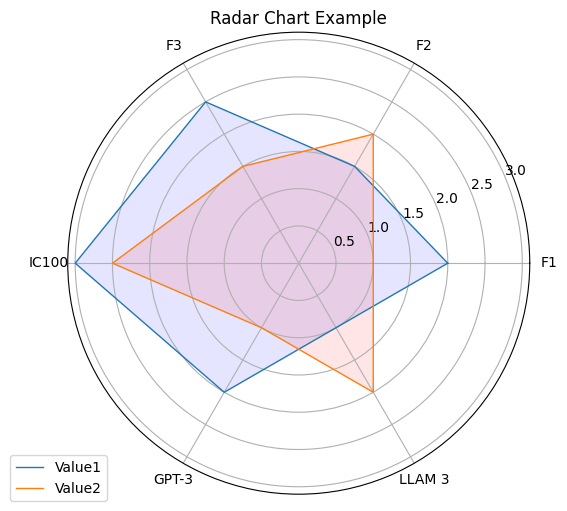

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Example synthetic data
data = {
    'Category': ['F1', 'F2', 'F3', 'IC100', 'GPT-3', 'LLAM 3'],
    'Value1': [2.0, 1.5, 2.5, 3.0, 2.0, 1.0],
    'Value2': [1.0, 2.0, 1.5, 2.5, 1.0, 2.0]
}

df = pd.DataFrame(data)

# Number of variables
categories = list(df['Category'])
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variables)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# First dataset
values = df['Value1'].tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='Value1')
ax.fill(angles, values, 'b', alpha=0.1)

# Second dataset
values = df['Value2'].tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label='Value2')
ax.fill(angles, values, 'r', alpha=0.1)

# Add labels
plt.xticks(angles[:-1], categories)

# Add a title
plt.title('Radar Chart Example')

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Add a thick arc around the circle
# arc_colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan']
# for i in range(N):
#     ax.plot([angles[i], angles[i+1]], [3, 3], color=arc_colors[i], linewidth=5, solid_capstyle='round')

# for j, color in enumerate(['black', 'grey', 'white']):
#     arc = Arc((0, 0), 2 * Y_SIZE, 2 * Y_SIZE, theta1=j * 120, theta2=j * 120 + 120, color=color, linewidth=10)
#     ax.add_patch(arc)

plt.show()
